In [3]:
from lux.lux import LUX
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Iris example

In [4]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
iris = datasets.load_iris()
features = ['sepal_length','sepal_width','petal_length','petal_width']
target = 'calss'
rs=42
fraction=0.3

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_iris = pd.DataFrame(iris.data,columns=features)
df_iris[target] = iris.target

#train classifier
train, test = train_test_split(df_iris, random_state=rs)
clf = svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

1.0

## Withoiut uncertainty of predictor 

In [5]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2],n_jobs=4)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

X does not have valid feature names, but SVC was fitted with feature names


In fact using: 0.8839285714285714 samples from train set wiuth class balance: 1.0


['IF petal_length  < 2.45 THEN class = 0 # 1.0\n']

In [6]:
#calculate decision tree score over this dataset
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


Accuracy : 0.9736842105263158


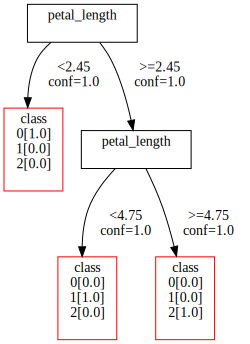

In [5]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

In [ ]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='petal_length',y='petal_width', data=train[['petal_length','petal_width', target]],hue=target,s=100)
graph.axhline(0.8,0, linestyle='--')
graph.axvline(4.75)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='petal_length',y='petal_width', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance')

### Without SHAP support

In [ ]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

In [ ]:
#calculate decision tree score over this dataset
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


In [ ]:
#have a look at the entire rule-based model that can be executed with https:://heartdroid.re
print(lux.to_HMR())

In [ ]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

## In fact, the explanation above is overcomplicated
The explanation can be made only using petal_lenght, but due to the greadiness of decision tree classifier, algorithm could not select correct split criterion for the fist place

In [ ]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='petal_length',y='petal_width', data=train[['petal_length','petal_width', target]],hue=target,s=100)
graph.axhline(0.8,0, linestyle='--')
graph.axvline(4.75)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='petal_length',y='petal_width', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance')

## Iris example with SHAP values
The explanation is more compact, and more consistend with the model, hence, the LUX tree with SHAP support obtains more accuray on the whole dataset, wing smaller than LUX tree without SHAP support

In [ ]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
iris = datasets.load_iris()
features = ['sepal_length','sepal_width','petal_length','petal_width']
target = 'calss'

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_iris = pd.DataFrame(iris.data,columns=features)
df_iris[target] = iris.target

#train classifier
train, test = train_test_split(df_iris, random_state=rs)
clf = svm.SVC(probability=True,random_state=rs)
clf.fit(train[features].values,train[target])
clf.score(test[features].values,test[target])

In [ ]:
def minmaxdf(df):
    maxv = df.max()
    return df/maxv

In [ ]:
import shap
shap.initjs()

explainer = shap.KernelExplainer(clf.predict_proba, train[features])
shap_values = explainer.shap_values(train[features])

In [ ]:
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None)

In [ ]:
shap_values=sum([abs(shap) for shap in shap_values])

In [ ]:
scaled_shap =minmaxdf(shap_values)

In [ ]:
#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = clf.predict_proba,classifier=clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = None,  instance_to_explain=iris_instance,class_names=[0,1,2],discount_importance=True)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

In [ ]:
#calculate decision tree score over this dataset
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


In [ ]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

In [ ]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='petal_length',y='petal_width', data=train[['petal_length','petal_width',target]],hue=target, alpha=clf.predict_proba(train[features]).max(axis=1),s=100)
graph.axvline(2.45)
graph.axvline(4.75)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='petal_length',y='petal_width', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance with SHAP support')

# Wine example

In [ ]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
wine = datasets.load_wine()

In [ ]:
features = wine['feature_names']
target = 'calss'
rs=42

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_wine = pd.DataFrame(wine.data,columns=features)
df_wine[target] = wine.target

#train classifier
train, test = train_test_split(df_wine, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

## Without predictor uncertainty

In [ ]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

In [ ]:
#calculate decision tree score over this dataset
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


In [ ]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

## Without SHAP

In [ ]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 20 instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1,2])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

In [ ]:
#calculate decision tree score over this dataset
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


In [ ]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

In [ ]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='od280/od315_of_diluted_wines',y='flavanoids', data=train[['od280/od315_of_diluted_wines','flavanoids',target]],hue=target, alpha=clf.predict_proba(train[features]).max(axis=1),s=100)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='od280/od315_of_diluted_wines',y='flavanoids', marker='o', s=200)
graph.axhline(1.4)
graph.axvline(2.205)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')

## With SHAP

In [ ]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(clf, train[features])
shap_values = explainer.shap_values(train[features],check_additivity=False)

In [ ]:
shap.summary_plot(shap_values, features=None, feature_names=features, max_display=None)

In [ ]:
shap_values=sum([abs(shap) for shap in shap_values])

In [ ]:
scaled_shap =minmaxdf(shap_values)

In [ ]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = scaled_shap,  instance_to_explain=iris_instance,class_names=[0,1,2],discount_importance=True)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

In [ ]:
#calculate decision tree score over this dataset
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


In [ ]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

In [ ]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='flavanoids',y='color_intensity', data=train[['flavanoids','color_intensity',target]],hue=target, alpha=clf.predict_proba(train[features]).max(axis=1),s=100)
graph.axvline(1.4)
graph.axhline(3.725)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='flavanoids',y='color_intensity', marker='o', s=200)
plt.title('Decision boundary created by LUX for particular instance SHAP support')

# Breast cancer

In [ ]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
cancer = datasets.load_breast_cancer()

In [ ]:
import xgboost as xgb
features = [f.replace(" ","_") for f in cancer['feature_names']]
target = 'calss'
rs=42

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_cancer = pd.DataFrame(cancer.data,columns=features)
df_cancer[target] = cancer.target

#train classifier
train, test = train_test_split(df_cancer, random_state=rs)
clf = RandomForestClassifier(random_state=42)#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features],train[target])
clf.score(test[features],test[target])

## Without predictor uncertinaty

In [ ]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 30% instances
lux = LUX(predict_proba = lambda x: np.round(clf.predict_proba(x)), neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

In [ ]:
#calculate decision tree score over this dataset
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


In [ ]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

## Without SHAP

In [ ]:
#pick some instance from datasetr
iris_instance = train[features].sample(1, random_state=42).values
iris_instance

#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 1, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], instance_to_explain=iris_instance,class_names=[0,1])

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

In [ ]:
#calculate decision tree score over this dataset
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


In [ ]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

In [ ]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_perimeter',y='worst_concave_points', data=train[['worst_perimeter','worst_concave_points',target]],hue=target, alpha=clf.predict_proba(train[features]).max(axis=1),s=100)
graph.axvline(105.95)
graph.axhline(0.14)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='worst_perimeter',y='worst_concave_points', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance without SHAP support')

## With SHAP

In [ ]:
import shap
shap.initjs()
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees


explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(train[features],check_additivity=True)

In [ ]:
shap.summary_plot(shap_values,train[features])#, features=None, feature_names=features, max_display=None)

In [ ]:
shap_values=sum([abs(shap) for shap in shap_values])

In [ ]:
scaled_shap =minmaxdf(shap_values)

In [ ]:
#train lux on neighbourhood equal 20% instances
lux = LUX(predict_proba = clf.predict_proba, neighborhood_size=int(len(train)*fraction),max_depth=2,  node_size_limit = 3, grow_confidence_threshold = 0 )
lux.fit(train[features], train[target], X_importances = scaled_shap,  instance_to_explain=iris_instance,class_names=[0,1],discount_importance=True)

#see the justification of the instance being classified for a given class
lux.justify(np.array(iris_instance))

In [ ]:
#calculate decision tree score over this dataset
import sys
sys.path.append('./pyuid3')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from pyuid3.data import Data
data = Data.parse_dataframe(test[features+[target]])
    
predictions = [int(x.get_name()) for x in lux.uid3.predict(data.instances)]
print(f'Accuracy : {accuracy_score(predictions, test[target])}')


In [ ]:
#prind the uncertain local tree for the given instance
import graphviz
lux.uid3.tree.save_dot('tree.dot')
graphviz.Source.from_file('tree.dot')

In [ ]:
plt.figure(figsize=(12,9))
graph=sns.scatterplot(x='worst_area',y='worst_concave_points', data=train[['worst_area','worst_concave_points',target]],hue=target, alpha=clf.predict_proba(train[features]).max(axis=1),s=100)
graph.axvline(830.75)
graph.axhline(0.14)
plt.scatter(data=pd.DataFrame(iris_instance,columns=features),x='worst_area',y='worst_concave_points', marker='o',color='r', s=200)
plt.title('Decision boundary created by LUX for particular instance with SHAP support')

In [ ]:
from lux.lux import LUX
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import svm
import numpy as np
import pandas as pd
# import some data to play with
iris = datasets.load_iris()
features = ['sepal_length','sepal_width','petal_length','petal_width']
target = 'calss'
rs=42
fraction=0.3

#create daatframe with columns names as strings (LUX accepts only DataFrames withj string columns names)
df_iris = pd.DataFrame(iris.data,columns=features)
df_iris[target] = iris.target

#train classifier
train, test = train_test_split(df_iris, random_state=rs)
clf = xgb.XGBClassifier()#svm.SVC(probability=True, random_state=rs)
clf.fit(train[features].values,train[target])
clf.score(test[features],test[target])

In [ ]:
explainer = shap.KernelExplainer(clf.predict_proba, train[features])
shap_values = explainer.shap_values(train[features])

In [ ]:
np.argmax(shap_values[0], axis=1)

In [ ]:
shap_values[0][:,2]

In [ ]:
explainer.expected_value

In [ ]:
shap_dict={}
expected_dict={}
expected_values = explainer.expected_value
for i,v in enumerate(shap_values):
    shap_dict[str(i)] = pd.DataFrame(v, columns = train.columns[:-1])
    expected_dict[str(i)] = expected_values[i]

In [ ]:
d=pd.concat(shap_dict,axis=1)

In [ ]:
d

In [ ]:
for i,r in d.iterrows():
    print(r.index.get_level_values(1).nunique())

In [ ]:
np.arange(12).reshape(3,4).mean(axis=1)

In [ ]:
pd.DataFrame(np.arange(12).reshape(3,4)).mean(axis=0)

In [ ]:
import numpy as np